In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

In [3]:
weights = 'yolov4-tiny.weights'
config = 'yolov4-tiny.cfg'
net = cv2.dnn.readNet(weights, config)
model = cv2.dnn_DetectionModel(net)
# you pick the size depending on the tradeoff between the detection and speed
model.setInputParams(size=(320, 320), scale=1/255)

In [4]:
def detect_people(img):
    results = []
    (class_ids, scores, bboxes) = model.detect(img)
    indices = cv2.dnn.NMSBoxes(bboxes, scores, 0.3, 0.5)
    for index in indices:
        # we only want to detect people
        if class_ids[index] == 0:
            (x, y, w, h) = bboxes[index]
            center_x = x + (w // 2)
            center_y = y + (h // 2)
            r = (scores[index], (x, y, x+w, y+h), (center_x, center_y))
            results.append(r)
    return results

In [5]:
dist_threshold = 180

In [6]:
def detect_social_distance(frame):
    results = detect_people(frame)
    # have a new empty set for our violations
    violate = set()
    # make sure that we have atleast 2 people detected
    if len(results) > 1:
        centroids = np.array([r[2] for r in results])
        D = dist.cdist(centroids, centroids, metric="euclidean")
        # loop over the upper triangular of the distance matrix
        for i in range(0, D.shape[0]):
            # i+1 as we don't want to compare the same median with itself
            for j in range(i + 1, D.shape[1]):
                # check to see if the distance between any two centroid 
                # pairs is less than the configured number of pixels
                if D[i, j] < dist_threshold:
                    # update our violation set with the indexes of
                    # the centroid pairs
                    violate.add(i)
                    violate.add(j)
    # loop over the results
    for (i, (score, bbox, centroid)) in enumerate(results):
        # extract the bounding box and centroid coordinates, then
        # initialize the color of the annotation
        (startX, startY, endX, endY) = bbox
        (cX, cY) = centroid
        color = (0, 255, 0)

        # if the index pair exists within the violation set, then update the color
        if i in violate:
            color = (0, 0, 255)
        # draw (1) a bounding box around the person and (2) the centroid coordinates of the person,
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        cv2.circle(frame, (cX, cY), 5, color, 5)

### let's try the model on an image

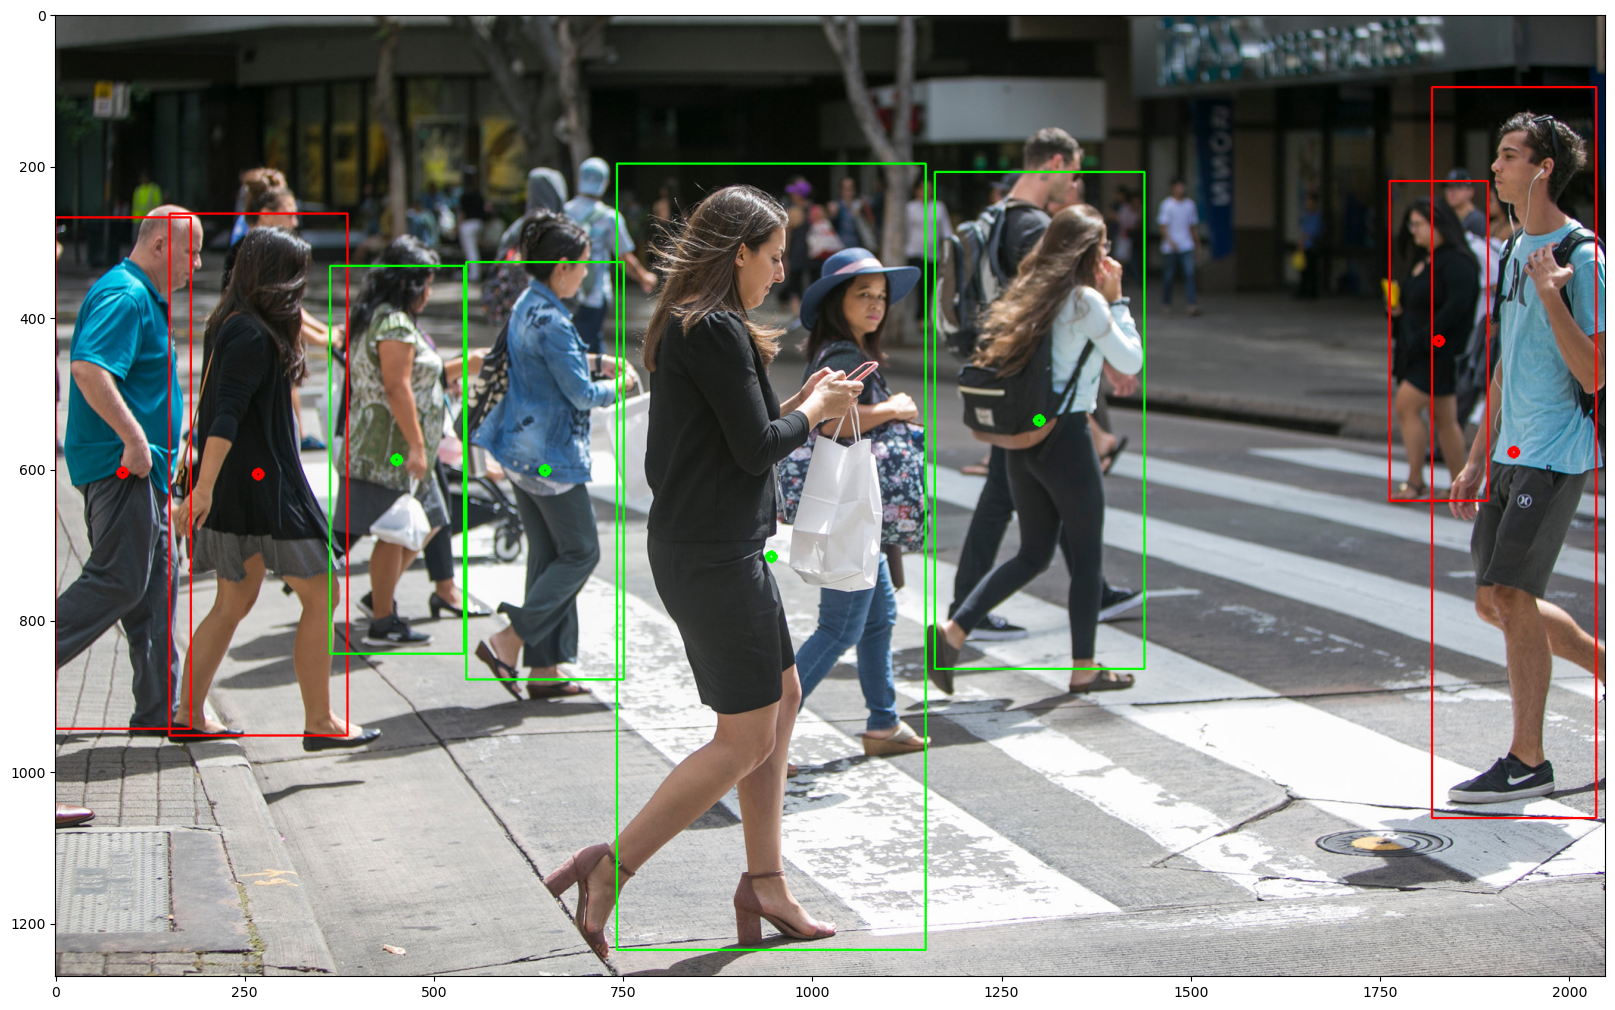

In [7]:
img = cv2.imread(os.path.join('Resources','people.jpg'))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 20))
detect_social_distance(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img);

In [8]:
vid_path = os.path.join('Resources', 'General_public_preview.mp4')
vid_capture = cv2.VideoCapture(vid_path)
if (vid_capture.isOpened() == False):
    print("Error opening the video file")
else:
    while(vid_capture.isOpened()):
        ret, frame = vid_capture.read()
        if ret == True:
            detect_social_distance(frame)
            # draw the total number of social distancing violations on the output frame
            text = "Social Distancing Violations: {}".format(len(violate))
            cv2.putText(frame, text, (10, frame.shape[0] - 25), cv2.FONT_HERSHEY_SIMPLEX, 0.85, (0, 0, 255), 3)
            cv2.imshow('Frame', frame)
            # 1 is in milliseconds, try to increase the value, say 5 and observe
            key = cv2.waitKey(1)
            # press q to quit
            if key == ord('q'):
                break
        else:
            break

# Release the video capture object
vid_capture.release()
cv2.destroyAllWindows()

NameError: name 'violate' is not defined